<h1 style="color: #002080; text-align: center;">House Prices Competition</h1>

<h2 style="color: #800000;">1- Import libraries and data</h2>

<h3><li style="color: #808000;">Import libraries:</li></h3>

In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import os
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor, ElasticNet, RidgeCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression

from xgboost import XGBRegressor

warnings.simplefilter(action='ignore')


<h3><li style="color: #808000;">Import description:</li></h3>

I will first transform the data description into a dictionary that will be useful:

In [2]:
# with open('data_description.txt') as f:
#     data_description = f.read()
#     print(data_description)

In [3]:
data_info = dict()
cur_feature = None
cur_txt = ""
match = None

for line in open('data_description.txt').readlines():
    if line.startswith('\t') or line.startswith(' ') or line.startswith('\n'):
        cur_txt += line
    else:
        if cur_feature is not None:
            data_info[cur_feature] = cur_txt
        
        match = re.match(r"(\w+): (.+)(\.|\n)", line)
        if not match:
            print(f"Can't parse line '{line}'")
            raise RuntimeError
        cur_feature = match.group(1)
        cur_txt = match.group(2)

print(data_info['Fence'])

Fence quality		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	



<h3><li style="color: #808000;">Import data:</li></h3>

In [4]:
original_train=pd.read_csv('train.csv')
train=original_train.copy()
original_test=pd.read_csv('test.csv')
test=original_test.copy()
display(train,test)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


<h2 style="color: #800000;">2- Data Information</h2>

<h3><li style="color: #808000;">General Information:</li></h3>

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<h3><li style="color: #808000;">Shape - Dublications - Missing Values:</li></h3>

In [6]:
print("\tShape: ")
print("\t - Train:", train.shape)
print("\t - Test :", test.shape)
print('---------------------------------------------------------')
print('\tNumber of duplicated values:')
print('\t - Train:', train.duplicated().sum())
print('\t - Test :', test.duplicated().sum())
print('---------------------------------------------------------')
print('\tNumber of missing values')
print('\t - Train:', sum(train.isnull().sum()))
print('\t - Test :', sum(test.isnull().sum()))

	Shape: 
	 - Train: (1460, 81)
	 - Test : (1459, 80)
---------------------------------------------------------
	Number of duplicated values:
	 - Train: 0
	 - Test : 0
---------------------------------------------------------
	Number of missing values
	 - Train: 6965
	 - Test : 7000


In [7]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls['percent'] = 100*nulls['Null Count']/1460
nulls.style.background_gradient('YlGnBu')
nulls = nulls[nulls['Null Count']!=0]
nulls

,Null Count,percent
Feature,,
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
GarageCond,81,5.547945
GarageType,81,5.547945


<h3><li style="color: #808000;">Correlation:</li></h3>

<AxesSubplot: >

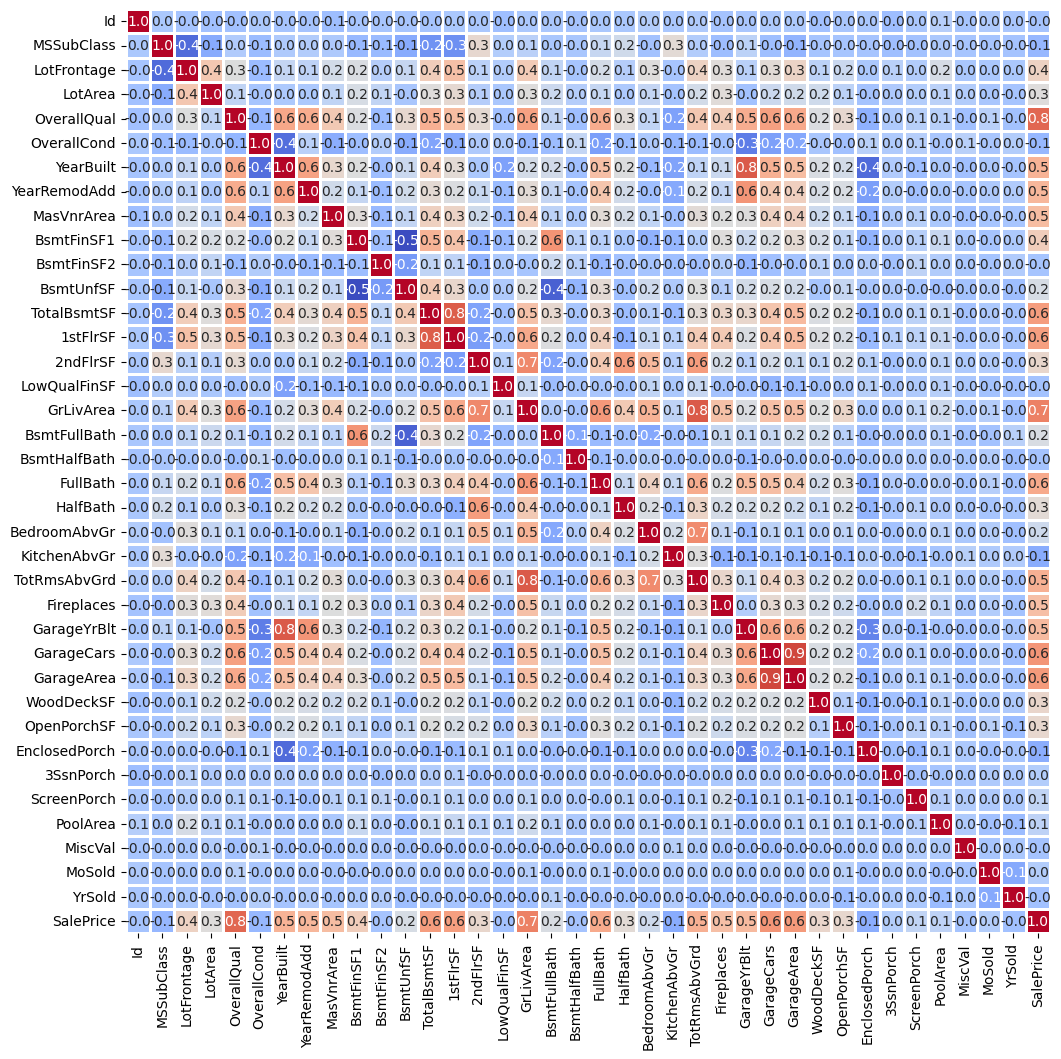

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(train.corr(), annot=True, fmt='.1f', cmap='coolwarm', square=True, linewidths=1, cbar=False, ax=ax)

In [9]:
train.corr()['SalePrice'].sort_values(ascending=False).to_frame().style \
    .format({'SalePrice': '{:.03f}'}).background_gradient('Blues')

,SalePrice
SalePrice,1.000
OverallQual,0.791
GrLivArea,0.709
GarageCars,0.640
GarageArea,0.623
TotalBsmtSF,0.614
1stFlrSF,0.606
FullBath,0.561
TotRmsAbvGrd,0.534
YearBuilt,0.523


<h3><li style="color: #808000;">Some Visualisations:</li></h3>

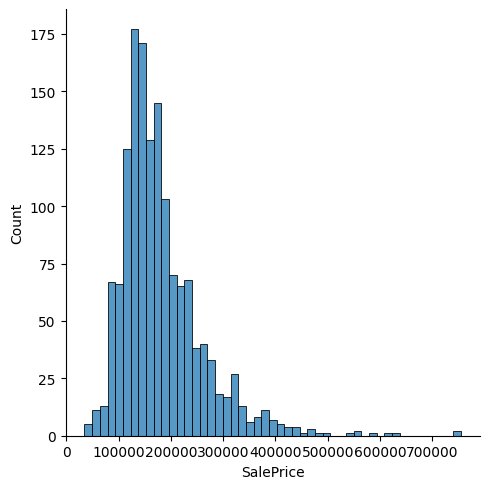

In [10]:
sns.displot(train.SalePrice)

In [11]:
categorical_features = [feature for feature in train.columns if train[feature].dtype == "object"] 
numerical_features = [feature for feature in train.drop('Id',axis=1).columns if feature not in categorical_features + ['SalePrice']]

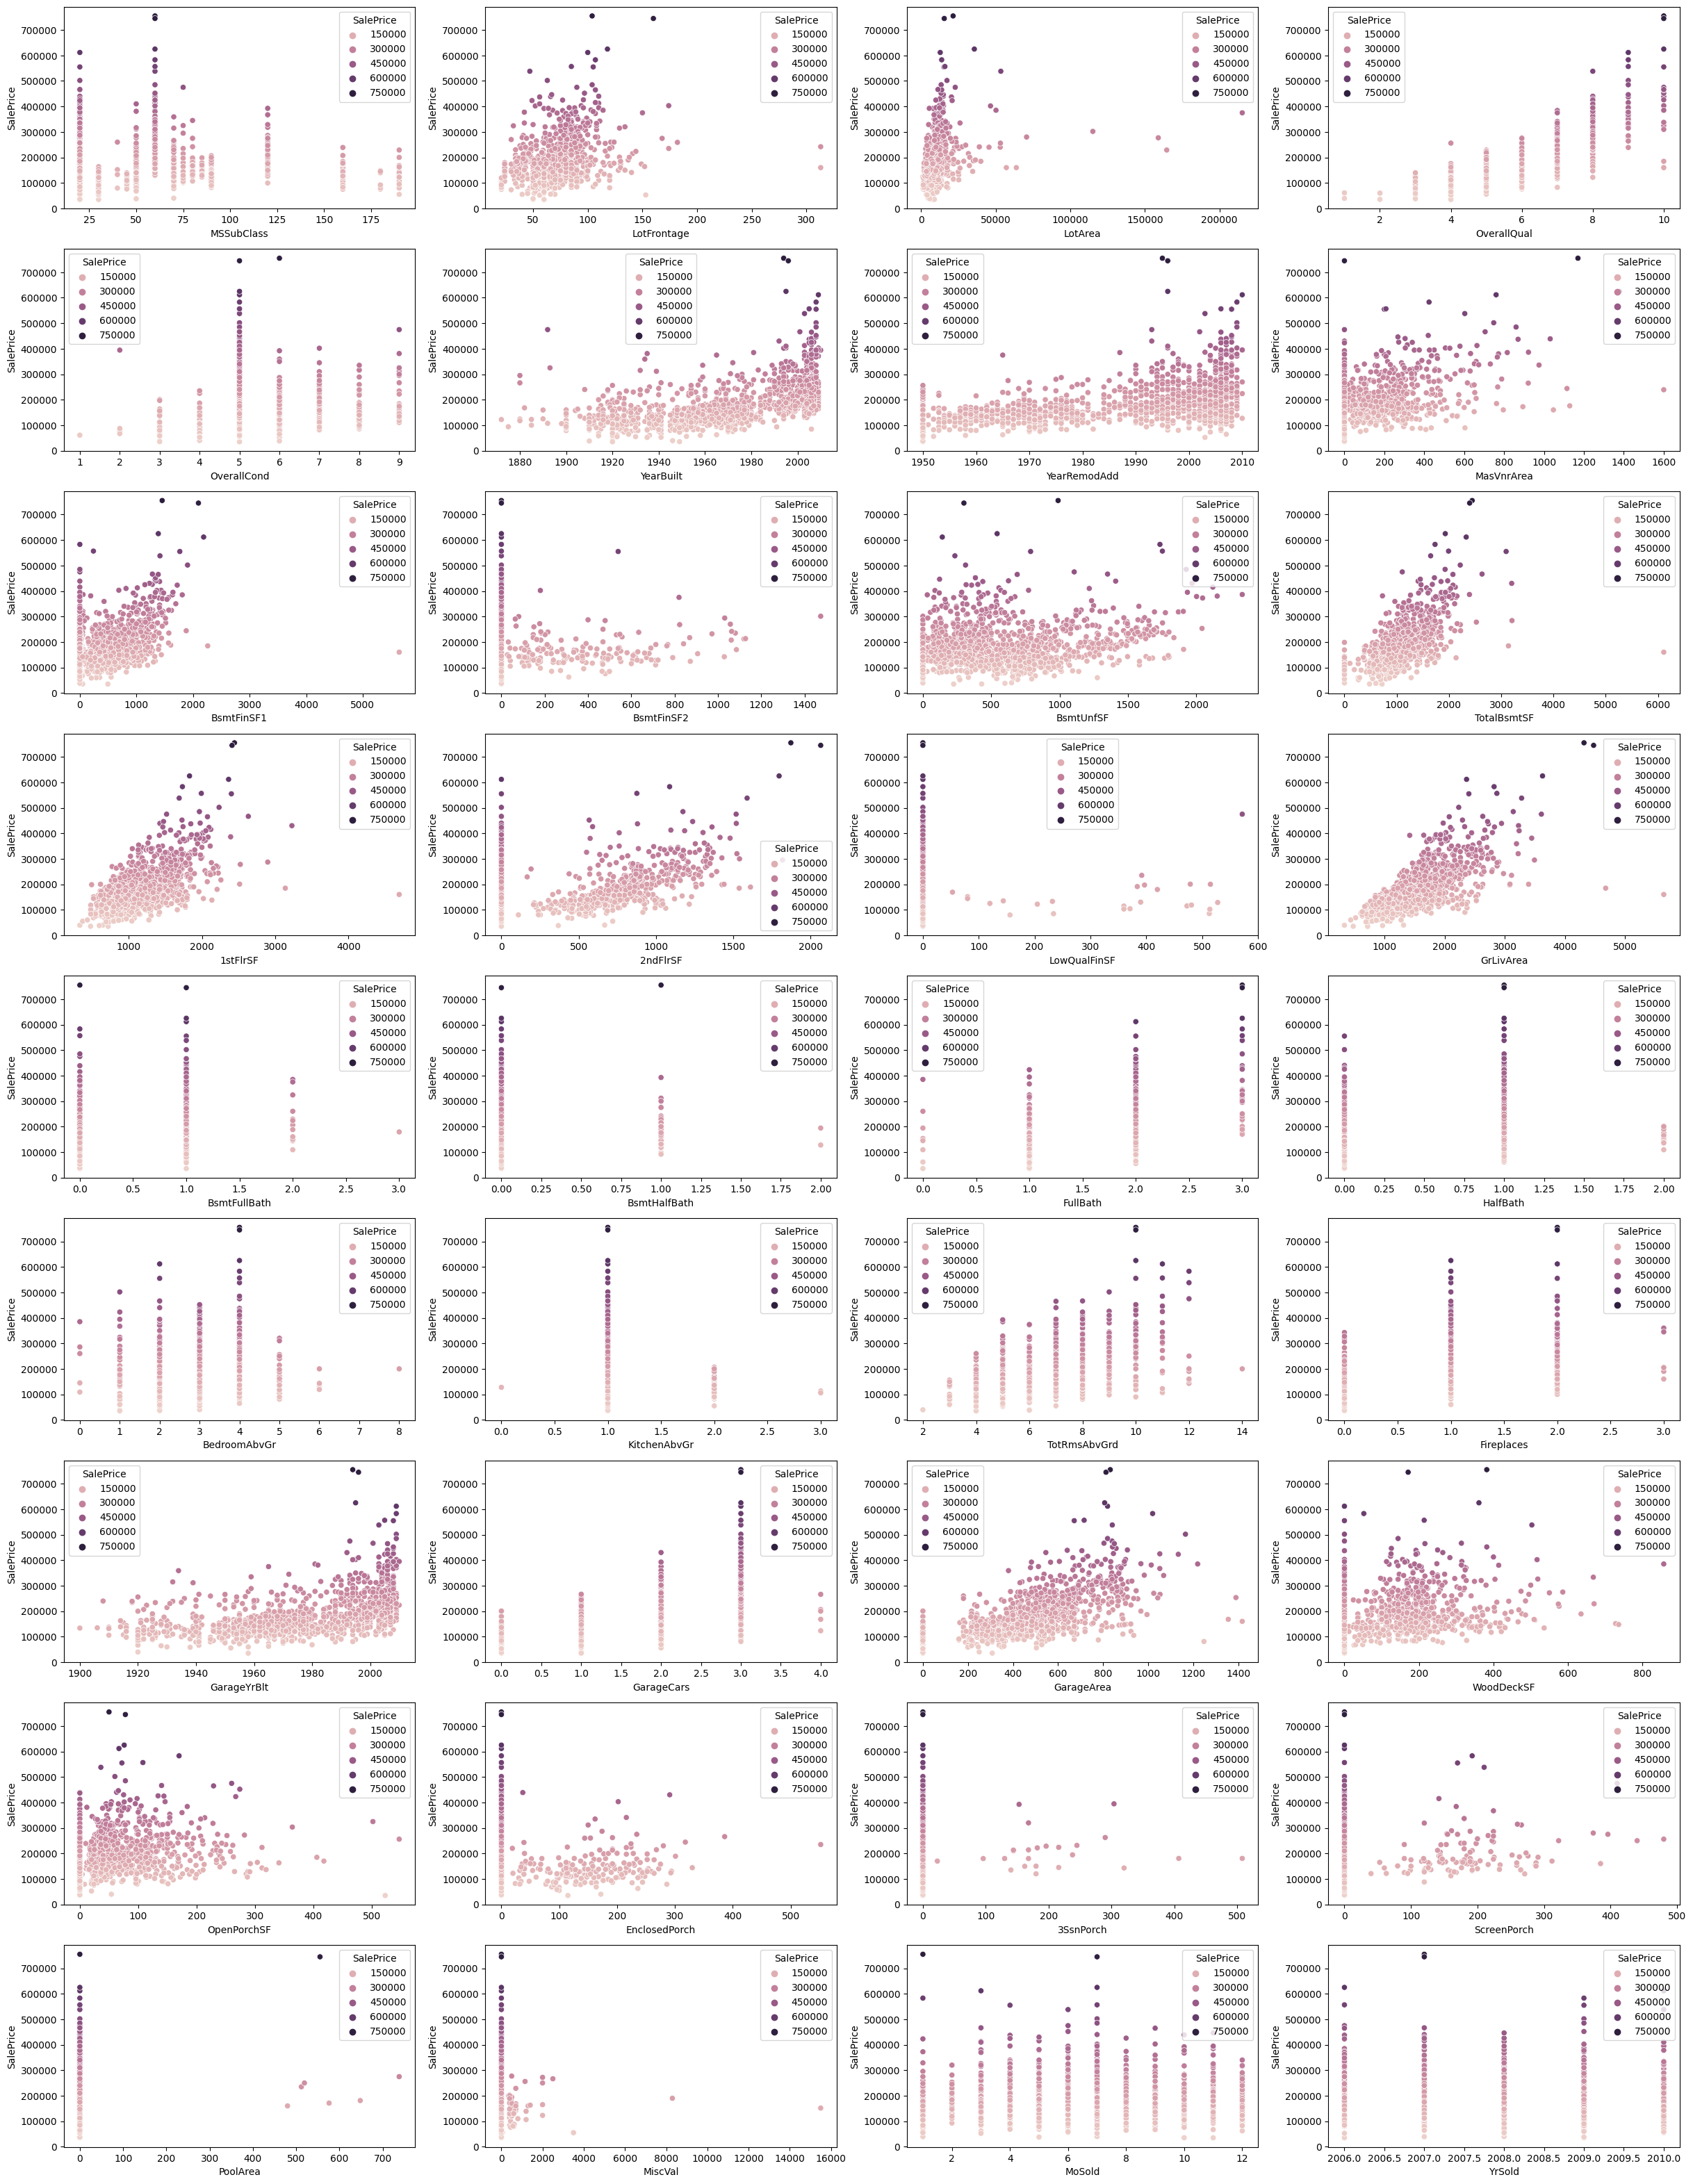

In [12]:
fig, ax = plt.subplots(9, 4, figsize=(30, 40))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice', data=train, ax=subplot, hue='SalePrice', cmap='Blues')

<h2 style="color: #800000;">3- Feature Engineering</h2>

<h3><li style="color: #808000;">Outliers:</li></h3>

In [13]:
train = train.loc[~((train['1stFlrSF'] > 4000) & (train.SalePrice < 300000))]
train = train.loc[~((train['BsmtFinSF1'] > 5000) & (train.SalePrice < 200000))]
train = train.loc[~((train['GarageArea'] > 1200) & (train.SalePrice < 400000))]
train = train.loc[~((train['GrLivArea'] > 4000) & (train.SalePrice < 300000))]
train = train.loc[~((train['LotFrontage'] > 300) & (train.SalePrice < 400000))]
train = train.loc[~((train['TotalBsmtSF'] > 5000) & (train.SalePrice < 300000))]

Let's create a reusable function for future needs:

In [14]:
def drop_train_outliers(train):
    train = train.loc[~((train['1stFlrSF'] > 4000) & (train.SalePrice < 300000))]
    train = train.loc[~((train['BsmtFinSF1'] > 5000) & (train.SalePrice < 200000))]
    train = train.loc[~((train['GarageArea'] > 1200) & (train.SalePrice < 400000))]
    train = train.loc[~((train['GrLivArea'] > 4000) & (train.SalePrice < 300000))]
    train = train.loc[~((train['LotFrontage'] > 300) & (train.SalePrice < 400000))]
    train = train.loc[~((train['TotalBsmtSF'] > 5000) & (train.SalePrice < 300000))]
    return train

Also, a function that calculates mutual info and returns table:

In [15]:
def print_mi(df: pd.DataFrame, columns: list, target: str):
    mutual_info = mutual_info_regression(df[columns].fillna(0), df[target], random_state=123)
    mutual_info = pd.Series(mutual_info, name=target)
    mutual_info.index = pd.Series(columns)
    return mutual_info.sort_values(ascending=False).to_frame()#.style.background_gradient("Blues")

print_mi(train, numerical_features, 'SalePrice')

,SalePrice
OverallQual,0.584821
GrLivArea,0.488298
TotalBsmtSF,0.376454
YearBuilt,0.370684
GarageArea,0.367112
GarageCars,0.355325
1stFlrSF,0.312210
MSSubClass,0.276398
FullBath,0.259834
GarageYrBlt,0.255539


<h2 style="color: #800000;">4- Feature Selection</h2>

<h3><li style="color: #808000;">Utilities:</li></h3>

Let's split utilities in 4 different categories

In [16]:
print(data_info['Utilities'].strip())

Type of utilities available		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only


In [17]:
train.Utilities.value_counts()

AllPub    1452
NoSeWa       1
Name: Utilities, dtype: int64

In [18]:
utils_factor, _ = train.Utilities.fillna('NA').factorize()
np.unique(utils_factor)

array([0, 1], dtype=int64)

In [19]:
mutual_info_regression(pd.Series(utils_factor).to_frame(), train.SalePrice)

array([0.00724973])

Default values

In [20]:
train.loc[:, 'Utilities_w'] = 0.  # Water
train.loc[:, 'Utilities_g'] = 0.  # Gas
train.loc[:, 'Utilities_e'] = 1.  # Electricity - All houses have electricity!
train.loc[:, 'Utilities_s'] = 0.  # Septic Tank

In [21]:
train.loc[train.Utilities.isin(['NoSeWa', 'NoSewr', 'AllPub']), 'Utilities_g'] = 1.
train.loc[train.Utilities.isin(['NoSewr', 'AllPub']), 'Utilities_w'] = 1.
train.loc[train.Utilities.isin(['AllPub']), 'Utilities_s'] = 1.

In [22]:
print_mi(
    train, 
    ['Utilities_w', 'Utilities_g', 'Utilities_e', 'Utilities_s'], 
    'SalePrice'
)

,SalePrice
Utilities_w,0.008134
Utilities_e,0.004587
Utilities_g,0.000000
Utilities_s,0.000000


In [23]:
train.drop('Utilities', axis=1, inplace=True)

<h3><li style="color: #808000;">Flags:</li></h3>

Boolean flags of existance of some house' items

In [24]:
print(data_info['CentralAir'].strip())

Central air conditioning
       N	No
       Y	Yes


In [25]:
train.CentralAir = train.CentralAir.fillna('N').replace({'N': 0., 'Y': 1.})

In [26]:
print_mi(
    train, 
    ['CentralAir'], 
    'SalePrice'
)

,SalePrice
CentralAir,0.073653


<h3><li style="color: #808000;">Other Fearures:</li></h3>

In [27]:
for key in ['Alley', 'Fence', 'BsmtQual', 'PoolQC', 'FireplaceQu', 'BsmtExposure', 'MasVnrType', '2ndFlrSF']:
    print(key)
    print(data_info[key].strip())
    print('-'*50)

Alley
Type of alley access to property
       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
--------------------------------------------------
Fence
Fence quality		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
--------------------------------------------------
BsmtQual
Evaluates the height of the basement
       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
--------------------------------------------------
PoolQC
Pool qualityDF		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
--------------------------------------------------
FireplaceQu
Fireplace quality
       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonr

In [28]:
train["Has_Alley"] = ((train['Alley'].notnull()) & (train['Alley'] != 'NA')).astype('int64')
train['Has_Fence'] = ((train['Fence'].notnull()) & (train['Fence'] != 'NA')).astype('int64')
train["Has_Bsmt"] = ((train['BsmtQual'].notnull()) & (train['BsmtQual'] != 'NA')).astype('int64')
train["Has_Fireplace"] = ((train['FireplaceQu'].notnull()) & (train['FireplaceQu'] != 'NA')).astype('int64')
train["Has_2ndFloor"] = (train["2ndFlrSF"] != 0).astype('int64')
train['Has_BsmtExposure'] = ((train['BsmtExposure'].notnull()) & (train['BsmtExposure'] != 'NA') & (train['BsmtExposure'] != 'No')).astype('int64')
train['Has_MasVnr'] = ((train['MasVnrType'].notnull()) & (train['MasVnrType'] != 'None')).astype('int64')
train["Has_Garage"] = train["GarageYrBlt"].notnull().astype('int64')

In [29]:
print_mi(
    train, 
    ['Has_Alley', 'Has_Fence', 'Has_Garage', 'Has_Bsmt', 'Has_Fireplace', 
     'Has_2ndFloor', 'Has_BsmtExposure', 'Has_MasVnr'], 
    'SalePrice'
)

,SalePrice
Has_Fireplace,0.162309
Has_MasVnr,0.071202
Has_Garage,0.055753
Has_BsmtExposure,0.040188
Has_Fence,0.033264
Has_Bsmt,0.021741
Has_2ndFloor,0.011381
Has_Alley,0.011144


**Not bad !**

<h3><li style="color: #808000;">Another thoughts on new features:</li></h3>

Areas features from other code notebooks:

In [30]:
liste = ['GrLivArea', 'LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF',
         'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'WoodDeckSF', 'OpenPorchSF',
         'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'OverallQual', 'OverallCond']
for key in liste:
    print(key)
    print(data_info[key].strip())
    print('-'*50)

GrLivArea
Above grade (ground) living area square feet
--------------------------------------------------
LotArea
Lot size in square feet
--------------------------------------------------
TotalBsmtSF
Total square feet of basement area
--------------------------------------------------
1stFlrSF
First Floor square feet
--------------------------------------------------
2ndFlrSF
Second floor square feet
--------------------------------------------------
TotalBsmtSF
Total square feet of basement area
--------------------------------------------------
FullBath
Full bathrooms above grade
--------------------------------------------------
HalfBath
Half baths above grade
--------------------------------------------------
BsmtFullBath
Basement full bathrooms
--------------------------------------------------
BsmtHalfBath
Basement half bathrooms
--------------------------------------------------
WoodDeckSF
Wood deck area in square feet
--------------------------------------------------
OpenPorc

In [31]:
train["Lot_occupation"] = train["GrLivArea"] / train["LotArea"]
train["Floors_Number"] = (train["TotalBsmtSF"] != 0).astype('int64') + (train["1stFlrSF"] != 0).astype('int64') + (train["2ndFlrSF"] != 0).astype('int64')
train['Total_Close_Live_Area'] = train['GrLivArea'] + train['TotalBsmtSF']
train['TotalBath'] = (train['FullBath'] + (0.5 * train['HalfBath']) + train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath']))

train['Outside_live_area'] =  train['WoodDeckSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

train['Total_usable_area'] = train['Total_Close_Live_Area'] + train['Outside_live_area']
train['Area_Quality_Indicator'] = train['Total_usable_area'] * train['OverallQual']
train['Area_Qual_Cond_Indicator'] = train['Total_usable_area'] * train['OverallQual'] * train['OverallCond']

Features with years:

In [32]:
for key in [key for key in data_info.keys() if 'Year' in key or 'Yr' in key]:
    print(key)
    print(data_info[key].strip())
    print('-'*70)

YearBuilt
Original construction date
----------------------------------------------------------------------
YearRemodAdd
Remodel date (same as construction date if no remodeling or additions)
----------------------------------------------------------------------
GarageYrBlt
Year garage was built
----------------------------------------------------------------------
YrSold
Year Sold (YYYY)
----------------------------------------------------------------------


In [33]:
train['House_Age'] = train['YrSold'] - train['YearBuilt']
train["House_FullAge"] = 2023 - train["YearBuilt"]

train['Garage_Age'] = train['YrSold'] - train['GarageYrBlt']
train["Garage_FullAge"] = 2023 - train["GarageYrBlt"]

train["Has_Remodels"] = (train["YearBuilt"] != train["YearRemodAdd"]).astype('int64')
train['House_Age2'] = train['YrSold'] - train['YearRemodAdd']

And qualities:

In [34]:
train['QualCondMul'] = train['OverallQual'] * train['OverallCond']
train['QualCondSum'] = train['OverallQual'] + train['OverallCond']
train['QualCondMed'] = (train['OverallQual'] + train['OverallCond']) / 2

In [35]:
print_mi(
    train, 
    ['Lot_occupation', 'Floors_Number', 'Total_Close_Live_Area', 'Outside_live_area', 'Total_usable_area', 
     'TotalBath', 'Area_Quality_Indicator', 'Area_Qual_Cond_Indicator', 
     'House_Age', 'House_FullAge', 'Garage_Age', 'Garage_FullAge', 'Has_Remodels', 'House_Age2', 
     'QualCondMul', 'QualCondSum', 'QualCondMed'], 
    'SalePrice'
)

,SalePrice
Area_Quality_Indicator,0.937318
Area_Qual_Cond_Indicator,0.738760
Total_Close_Live_Area,0.667993
Total_usable_area,0.643114
QualCondMul,0.429814
House_FullAge,0.368620
QualCondSum,0.350878
House_Age,0.349051
TotalBath,0.342739
QualCondMed,0.338858


<h3><li style="color: #808000;">Qualities:</li></h3>

All qualities will replace with its grade from 0 (NA) to 5 (Excellent)

In [36]:
qual_cols = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageQual', 'GarageCond', 'PoolQC']
nulls = pd.DataFrame(train[qual_cols].isnull().sum().sort_values(ascending=False))
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls['Percent'] = 100*nulls['Null Count']/1460
nulls.style.background_gradient('YlGnBu')
nulls = nulls[nulls['Null Count']!=0]
nulls

,Null Count,Percent
Feature,,
PoolQC,1447,99.109589
FireplaceQu,689,47.191781
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtQual,37,2.534247
BsmtCond,37,2.534247


In [37]:
qualities = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
quality_enc = dict(zip(qualities, np.arange(len(qualities))))
quality_enc

{'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

Now let's build calsses that will encode features:

In [38]:
quality_features = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageQual', 'GarageCond', 'PoolQC'
]

In [39]:
class QualitiesOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.qualities = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
        self.qualities_enc = dict(zip(self.qualities, np.arange(len(self.qualities))))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.fillna('NA')
        return X_copy.replace(self.qualities_enc) 

Other Ordinal

In [40]:
other_ordinal_features = [
    'LotShape', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'Functional', 'Fence', 
]

In [41]:
class OrdinalFeaturesEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lot_shape_types = ['NA', 'IR3', 'IR2', 'IR1', 'Reg']
        self.lot_shape_enc = dict(zip(self.lot_shape_types, np.arange(len(self.lot_shape_types))))
        
        self.fin_types = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
        self.fin_types_enc = dict(zip(self.fin_types, np.arange(len(self.fin_types))))
        
        self.central_air_enc = {'N': 0, 'Y': 1}
        
        self.functional_types = ['NA', 'Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
        self.functional_enc = dict(zip(self.functional_types, np.arange(len(self.functional_types))))
        
        self.fence_types = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
        self.fence_enc = dict(zip(self.fence_types, np.arange(len(self.fence_types))))
    
    def fit(self, X, y=None):    
        return self
    
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        na_cols = ['LotShape', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence']
        X_copy.loc[:, na_cols] = X_copy[na_cols].fillna('NA')
        X_copy.loc[:, 'CentralAir'] = X_copy['CentralAir'].fillna('N')
        
        X_copy.loc[:, 'LotShape'] = X_copy['LotShape'].replace(self.lot_shape_enc)
        X_copy.loc[:, ['BsmtFinType1', 'BsmtFinType2']] = X_copy[['BsmtFinType1', 'BsmtFinType2']].replace(self.fin_types_enc)
        X_copy.loc[:, 'CentralAir'] = X_copy['CentralAir'].replace(self.central_air_enc)
        X_copy.loc[:, 'Functional'] = X_copy['Functional'].replace(self.functional_enc)
        X_copy.loc[:, 'Fence'] = X_copy['Fence'].replace(self.fence_enc)
        
        return X_copy

New features creator

In [42]:
class FeaturesCreator(BaseEstimator, TransformerMixin):
    def __init__(self, drop: list = ['Id', 'Utilities']):
        self.drop = drop
        self.competition_year = 2023
    
    def fit(self, X, y=None):    
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = self._add_utilities_features(X_copy)
        X_copy = self._add_flags(X_copy)
        X_copy = self._add_area_features(X_copy)
        X_copy = self._add_year_features(X_copy)
        X_copy = self._add_qual_features(X_copy)
        
        if len(self.drop):
            X_copy = X_copy.drop(self.drop, axis=1)
        
        return X_copy
        
    def _add_utilities_features(self, X):
        X.loc[:, 'Utilities_w'] = 0.
        X.loc[:, 'Utilities_g'] = 0.
        X.loc[:, 'Utilities_e'] = 1.
        X.loc[:, 'Utilities_s'] = 0.

        X.loc[X.Utilities.isin(['NoSeWa', 'NoSewr', 'AllPub']), 'Utilities_g'] = 1.
        X.loc[X.Utilities.isin(['NoSewr', 'AllPub']), 'Utilities_w'] = 1.
        X.loc[X.Utilities.isin(['AllPub']), 'Utilities_s'] = 1.

        return X
    
    def _add_flags(self, X):
        X["Has_Alley"] = ((X['Alley'].notnull()) & (X['Alley'] != 'NA')).astype('int64')
        X['Has_Fence'] = ((X['Fence'].notnull()) & (X['Fence'] != 'NA')).astype('int64')
        X["Has_Garage"] = X["GarageYrBlt"].notnull().astype('int64')
        X["Has_Bsmt"] = ((X['BsmtQual'].notnull()) & (X['BsmtQual'] != 'NA')).astype('int64')
        X["Has_Fireplace"] = ((X['FireplaceQu'].notnull()) & (X['FireplaceQu'] != 'NA')).astype('int64')
        X["Has_2ndFloor"] = (X["2ndFlrSF"] != 0).astype('int64')
        X['Has_BsmtExposure'] = ((X['BsmtExposure'].notnull()) & (X['BsmtExposure'] != 'NA') & (X['BsmtExposure'] != 'No')).astype('int64')
        X['Has_MasVnr'] = ((X['MasVnrType'].notnull()) & (X['MasVnrType'] != 'None')).astype('int64')
        return X
    
    def _add_area_features(self, X):
        X["Lot_occupation"] = X["GrLivArea"] / X["LotArea"]
        X["Floors_Number"] = (X["TotalBsmtSF"] != 0).astype('int64')+(X["1stFlrSF"] != 0).astype('int64')+(X["2ndFlrSF"] != 0).astype('int64')
        X['Total_Close_Live_Area'] = X['GrLivArea'] + X['TotalBsmtSF'] 
        X['Outside_live_area'] =  X['WoodDeckSF'] + X['OpenPorchSF']+X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
        X['Total_usable_area'] = X['Total_Close_Live_Area'] + X['Outside_live_area']
        X['TotalBath'] = (X['FullBath'] + (0.5 * X['HalfBath']) +\
            X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))
        X['Area_Quality_Indicator'] = X['Total_usable_area'] * X['OverallQual']
        X['Area_Qual_Cond_Indicator'] = X['Total_usable_area'] * X['OverallQual'] * X['OverallCond']
        
        return X
    
    def _add_year_features(self, X): 
        X['House_Age'] = X['YrSold'] - X['YearBuilt']
        X["House_FullAge"] = self.competition_year - X["YearBuilt"]

        X['Garage_Age'] = X['YrSold'] - X['GarageYrBlt']
        X["Garage_FullAge"] = self.competition_year - X["GarageYrBlt"]

        X["Has_Remodels"] = (X["YearBuilt"] != X["YearRemodAdd"]).astype('int64')
        X['House_Age2'] = X['YrSold'] - X['YearRemodAdd']
        return X
    
    def _add_qual_features(self, X):
        X['QualCondMul'] = X['OverallQual'] * X['OverallCond']
        X['QualCondSum'] = X['OverallQual'] + X['OverallCond']
        X['QualCondMed'] = (X['OverallQual'] + X['OverallCond']) / 2
        return X

<h3><li style="color: #808000;">Pipeline building:</li></h3>

In [43]:
numerical_transformer = Pipeline(steps=[  
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
  ])

categorical_transformer = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='constant', fill_value='NA_None')),
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
  ])

One Hot Encoder

In [44]:
ohe_features = list(set(categorical_features) - set(qual_cols) - set(other_ordinal_features) - {'Utilities'})
preprocessor = ColumnTransformer([
    ('quality', QualitiesOrdinalEncoder(), qual_cols),
    ('other_ordinal', OrdinalFeaturesEncoder(), other_ordinal_features),
    ('one_hot', categorical_transformer, ohe_features)
   ], 
   remainder=numerical_transformer
  )

In [45]:
numerical_transformer_scaled = Pipeline(steps=[  
    ('SimpleImputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('StandardScaler', StandardScaler())
  ])

preprocessor_scaled = ColumnTransformer([
    ('quality', QualitiesOrdinalEncoder(), qual_cols),
    ('other_ordinal', OrdinalFeaturesEncoder(), other_ordinal_features),
    ('one_hot', categorical_transformer, ohe_features)
   ], 
   remainder=numerical_transformer_scaled
  )

<h2 style="color: #800000;">5- Modeling</h2>

In [47]:
X_train = original_train.copy()
X_train = drop_train_outliers(X_train)

y = X_train.SalePrice
X_train = X_train.drop('SalePrice', axis=1)
X_test = original_test.copy()

X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_train, y, train_size=0.8, random_state=0)

<h3><li style="color: #808000;">XGB:</li></h3>

In [48]:
xgb_pipeline = Pipeline([
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=1))
  ])

xgb_pipeline.fit(X_train_1, y_train_1)
xgb_preds = xgb_pipeline.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, xgb_preds))

MAE: 14927.773759664948


In [49]:
xgb_params = dict(n_estimators=5000,
                  subsample=0.6,
                  colsample_bytree=0.6,
                  colsample_bylevel=0.8,
                  max_depth=5, 
                  min_child_weight=2, 
                  learning_rate=0.005,
                  random_state=1)

xgbr_clf = XGBRegressor(**xgb_params)
xgb_pipe_tuned = Pipeline([
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor),
    ('regressor', xgbr_clf)
  ])

xgb_pipe_tuned.fit(X_train_1, y_train_1)
xgb_t_preds = xgb_pipe_tuned.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, xgb_t_preds))

MAE: 13448.031921176977


<h3><li style="color: #808000;">Liner regression:</li></h3>

In [50]:
lasso_pipe = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor_scaled),
    ('regressor', Lasso(random_state=1))
  ])

lasso_pipe.fit(X_train_1, y_train_1)
lasso_preds = lasso_pipe.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, lasso_preds))

MAE: 29649.869035968077


In [51]:
lasso_params = {'alpha': np.linspace(0, 0.03, 20)}

lasso_pipe_tuned = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor_scaled),
    ('regressor', GridSearchCV( 
        Lasso(random_state=1),
        lasso_params, 
        n_jobs=-1,
        scoring='neg_mean_absolute_error'
    ))
  ])

lasso_pipe_tuned.fit(X_train_1, y_train_1)
lasso_t_preds = lasso_pipe_tuned.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, lasso_t_preds))

MAE: 30467.839659552566


In [52]:
ridge_pipe = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor_scaled),
    ('regressor', Ridge(alpha=100, random_state=1))
  ])
ridge_pipe.fit(X_train_1, y_train_1)
ridge_preds = ridge_pipe.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, ridge_preds))

MAE: 16588.01657761547


In [53]:
ridge_params = {'alpha': np.linspace(1, 500, 20)}

ridge_pipe_tuned = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor_scaled),
    ('regressor', GridSearchCV(
        Ridge(random_state=1),
        ridge_params, 
        n_jobs=-1,
        scoring='neg_mean_absolute_error'
    ))
  ])

ridge_pipe_tuned.fit(X_train_1, y_train_1)
ridge_t_preds = ridge_pipe_tuned.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, ridge_t_preds))
ridge_pipe_tuned.named_steps['regressor'].best_params_

MAE: 15652.83483041829


{'alpha': 27.263157894736842}

In [54]:
enet_pipe = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor_scaled),
    ('regressor', ElasticNet(alpha=100, random_state=1))
  ])
enet_pipe.fit(X_train_1, y_train_1)
enet_preds = enet_pipe.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, enet_preds))

MAE: 47263.83858913171


<h3><li style="color: #808000;">Random Forest Regressor:</li></h3>

In [55]:
rf_params = {
    'n_estimators': 1366,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 110,
    'bootstrap': False
  }
rf_pipe = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**rf_params, random_state=1))
  ])
rf_pipe.fit(X_train_1, y_train_1)
rf_preds = rf_pipe.predict(X_valid_1)

print('MAE:', mean_absolute_error(y_valid_1, rf_preds))
rf_test = rf_pipe.predict(X_test)

output = pd.DataFrame({'Id': X_test.Id,
                       'SalePrice': rf_test})
output.to_csv('submission_rf.csv', index=False)

MAE: 15103.905802679708


<h3><li style="color: #808000;">Best Models:</li></h3>

In [56]:
xgb_pipe_tuned_full = Pipeline([
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**xgb_params))
  ])

xgb_pipe_tuned_full.fit(X_train, y)
xgb_test_1 = xgb_pipe_tuned_full.predict(X_test)

output = pd.DataFrame({'Id': X_test.Id,
                       'SalePrice': xgb_test_1})
output.to_csv('submission_xgb.csv', index=False)

<h3><li style="color: #808000;">Stack Results:</li></h3>

In [57]:
ridge_pipe_tuned_full = Pipeline(steps=[
    ('features', FeaturesCreator()),
    ('preprocessor', preprocessor_scaled),
    ('regressor', Ridge(alpha=27.263157894736842, random_state=1),)
  ])

estimators = [
    ("pipe_xgb", xgb_pipe_tuned_full),
    ("pipe_rf", rf_pipe),
    ("pipe_ridge", ridge_pipe_tuned_full),
  ]

stacking_regressor = StackingRegressor(
    estimators=estimators, 
    final_estimator=RidgeCV(),
    n_jobs=-1
  )

<h2 style="color: #800000;">6- Last Step</h2>

In [58]:
stacking_regressor.fit(X_train, y)
stacking_test = stacking_regressor.predict(X_test)

In [59]:
output = pd.DataFrame({'Id': X_test.Id,
                       'SalePrice': stacking_test})
output.to_csv('submission_stack_fv.csv', index=False)

In [60]:
pred_df = pd.read_csv('submission_stack_fv.csv')
pred_df

,Id,SalePrice
0,1461,124761.360903
1,1462,168727.466026
2,1463,185935.169132
3,1464,195127.851454
4,1465,187285.333088
...,...,...
1454,2915,82561.509803
1455,2916,78516.640067
1456,2917,167561.670249
1457,2918,116464.195794
